# Preprocess LSOA level data

In [20]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

In [38]:
def analyze_lsoa_dataset(file_path, lsoa_column_name, output_dir="data/preprocessed"):
    """
    Process a dataset that already contains LSOA codes, analyze missing values,
    and generate visualizations for reporting.

    Parameters:
    file_path (str): Path to the dataset file (CSV, Excel, etc.)
    lsoa_column_name (str): Name of the column containing LSOA codes
    output_dir (str): Directory to save output files and visualizations

    Returns:
    pd.DataFrame: Cleaned dataset with standardized LSOA codes
    """
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Generate a timestamp for unique filenames
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Extract filename without extension for reporting
    base_filename = os.path.basename(file_path).split('.')[0]

    print(f"Processing dataset: {file_path}")

    # Determine file type and load accordingly
    if file_path.endswith('.csv'):
        df = pd.read_csv(file_path, low_memory=False)
    elif file_path.endswith(('.xls', '.xlsx')):
        df = pd.read_excel(file_path)
    else:
        raise ValueError("Unsupported file format. Please use CSV or Excel.")

    print(f"Original dataset shape: {df.shape}")

    # Save a summary of the original dataset
    with open(f"{output_dir}/{base_filename}_{timestamp}_summary.txt", "w") as f:
        f.write(f"Dataset Analysis: {file_path}\n")
        f.write(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Original dataset shape: {df.shape}\n\n")
        f.write("Column Names:\n")
        for col in df.columns:
            f.write(f"- {col}\n")
        f.write("\n")

    # Basic data cleaning
    # 1. Remove duplicate rows
    df_clean = df.drop_duplicates()
    duplicates_removed = len(df) - len(df_clean)
    print(f"Removed {duplicates_removed} duplicate rows. New shape: {df_clean.shape}")

    # 2. Standardize column names
    original_columns = df_clean.columns.tolist()
    df_clean.columns = [col.lower().replace(' ', '_') for col in df_clean.columns]
    lsoa_column_name = lsoa_column_name.lower().replace(' ', '_')

    # 3. Handle the LSOA column
    # Make sure LSOA column exists
    if lsoa_column_name not in df_clean.columns:
        raise ValueError(f"LSOA column '{lsoa_column_name}' not found in dataset. Available columns: {df_clean.columns.tolist()}")

    # Standardize LSOA codes (ensure proper format E01######)
    df_clean[lsoa_column_name] = df_clean[lsoa_column_name].astype(str)

    # Clean LSOA codes (remove spaces, ensure proper format)
    df_clean[lsoa_column_name] = df_clean[lsoa_column_name].str.strip()

    # Check for and fix common LSOA format issues
    # Example: Add 'E01' prefix if it's just numeric and 6 digits
    def standardize_lsoa(lsoa_code):
        # Skip NaN values
        if lsoa_code.lower() in ['nan', 'none', '']:
            return np.nan

        # Remove any spaces or special characters
        lsoa_code = re.sub(r'[^a-zA-Z0-9]', '', lsoa_code)

        # If it's a numeric string of exactly 6 digits, add 'E01' prefix
        if lsoa_code.isdigit() and len(lsoa_code) == 6:
            return 'E01' + lsoa_code

        # If it already has the proper format (E01 followed by 6 digits)
        if re.match(r'^E01\d{6}$', lsoa_code):
            return lsoa_code

        # Otherwise, return the original code but flag it
        if lsoa_code != '':
            print(f"Potential incorrect LSOA code: {lsoa_code}")
        return lsoa_code

    df_clean[lsoa_column_name] = df_clean[lsoa_column_name].apply(standardize_lsoa)

    # Count standardized vs non-standardized LSOA codes
    standardized_lsoa_count = df_clean[lsoa_column_name].apply(
        lambda x: bool(isinstance(x, str) and re.match(r'^E01\d{6}$', x))
    ).sum()

    print(f"Standardized LSOA codes: {standardized_lsoa_count}/{len(df_clean)} ({standardized_lsoa_count/len(df_clean):.2%})")

    # 4. Create a standardized LSOA column if original needs to be preserved
    df_clean['lsoa_code'] = df_clean[lsoa_column_name]

    # 5. Analyze missing values across all columns
    missing_values = df_clean.isna().sum()
    missing_percentage = (missing_values / len(df_clean)) * 100
    missing_df = pd.DataFrame({
        'Column': missing_values.index,
        'Missing Values': missing_values.values,
        'Percentage': missing_percentage.values
    })
    missing_df = missing_df.sort_values('Missing Values', ascending=False).reset_index(drop=True)

    # Save missing values report
    missing_df.to_csv(f"{output_dir}/{base_filename}_{timestamp}_missing_values.csv", index=False)

    print("\nMissing Values Analysis:")
    print(missing_df)

    # 6. Generate visualizations for the report

    # 6.1 Missing values heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(df_clean.isna(), cbar=False, yticklabels=False, cmap='viridis')
    plt.title('Missing Values Heatmap', fontsize=16)
    plt.xlabel('Columns', fontsize=12)
    plt.ylabel('Records', fontsize=12)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{base_filename}_{timestamp}_missing_heatmap.png", dpi=300)

    # 6.2 Bar chart of missing values by column
    plt.figure(figsize=(14, 8))
    top_missing = missing_df[missing_df['Missing Values'] > 0].head(20)  # Top 20 columns with missing values

    if not top_missing.empty:
        sns.barplot(x='Percentage', y='Column', data=top_missing)
        plt.title('Percentage of Missing Values by Column', fontsize=16)
        plt.xlabel('Missing Values (%)', fontsize=12)
        plt.ylabel('Column', fontsize=12)
        plt.tight_layout()
        plt.savefig(f"{output_dir}/{base_filename}_{timestamp}_missing_barchart.png", dpi=300)
    else:
        print("No missing values to plot")

    # 6.3 LSOA code quality visualization
    plt.figure(figsize=(10, 6))
    lsoa_quality = pd.Series({
        'Valid Format': standardized_lsoa_count,
        'Invalid/Missing': len(df_clean) - standardized_lsoa_count
    })
    lsoa_quality.plot(kind='pie', autopct='%1.1f%%', colors=['#66b3ff', '#ff9999'])
    plt.title('LSOA Code Quality', fontsize=16)
    plt.ylabel('')  # Hide the ylabel
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{base_filename}_{timestamp}_lsoa_quality.png", dpi=300)

    # 7. Data type analysis
    dtypes_dict = {str(col): str(dtype) for col, dtype in zip(df_clean.columns, df_clean.dtypes)}
    dtypes_df = pd.DataFrame({
        'Column': list(dtypes_dict.keys()),
        'Data Type': list(dtypes_dict.values())
    })
    dtypes_df.to_csv(f"{output_dir}/{base_filename}_{timestamp}_data_types.csv", index=False)

    # 8. Save the cleaned dataset
    cleaned_file_path = f"{output_dir}/{base_filename}_cleaned.csv"
    df_clean.to_csv(cleaned_file_path, index=False)
    print(f"\nCleaned dataset saved to: {cleaned_file_path}")

    # 9. Generate a comprehensive report
    with open(f"{output_dir}/{base_filename}_{timestamp}_report.txt", "w") as f:
        f.write(f"LSOA Dataset Analysis Report\n")
        f.write(f"===========================\n\n")
        f.write(f"Dataset: {file_path}\n")
        f.write(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")

        f.write(f"Dataset Statistics:\n")
        f.write(f"------------------\n")
        f.write(f"Original records: {len(df)}\n")
        f.write(f"Cleaned records: {len(df_clean)}\n")
        f.write(f"Duplicates removed: {duplicates_removed}\n")
        f.write(f"Total columns: {len(df_clean.columns)}\n\n")

        f.write(f"LSOA Code Analysis:\n")
        f.write(f"-----------------\n")
        f.write(f"LSOA column: {lsoa_column_name}\n")
        f.write(f"Records with standardized LSOA codes: {standardized_lsoa_count} ({standardized_lsoa_count/len(df_clean):.2%})\n")
        f.write(f"Records with invalid or missing LSOA codes: {len(df_clean) - standardized_lsoa_count} ({(len(df_clean) - standardized_lsoa_count)/len(df_clean):.2%})\n\n")

        f.write(f"Missing Values Summary:\n")
        f.write(f"---------------------\n")
        f.write(f"Columns with no missing values: {sum(missing_values == 0)}\n")
        f.write(f"Columns with missing values: {sum(missing_values > 0)}\n\n")

        if sum(missing_values > 0) > 0:
            f.write("Top 10 columns with most missing values:\n")
            for i, row in missing_df[missing_df['Missing Values'] > 0].head(10).iterrows():
                f.write(f"- {row['Column']}: {row['Missing Values']} values ({row['Percentage']:.2f}%)\n")

        f.write("\nGenerated Visualizations:\n")
        f.write(f"------------------------\n")
        f.write(f"1. Missing Values Heatmap: {base_filename}_{timestamp}_missing_heatmap.png\n")
        if not top_missing.empty:
            f.write(f"2. Missing Values Bar Chart: {base_filename}_{timestamp}_missing_barchart.png\n")
        f.write(f"3. LSOA Code Quality Pie Chart: {base_filename}_{timestamp}_lsoa_quality.png\n")

        f.write("\nNext Steps Recommendation:\n")
        f.write(f"------------------------\n")
        if (len(df_clean) - standardized_lsoa_count)/len(df_clean) > 0.05:
            f.write("- High priority: Address the invalid or missing LSOA codes (>5% of dataset)\n")

        if missing_df['Percentage'].max() > 10:
            f.write("- Consider imputation strategies for columns with >10% missing values\n")

        f.write("- Review data types and ensure they are appropriate for analysis\n")
        f.write("- Consider spatial validation with Greater Manchester LSOA boundaries\n")

    print(f"\nAnalysis report saved to: {output_dir}/{base_filename}_{timestamp}_report.txt")

    return df_clean, {
        'cleaned_file': cleaned_file_path,
        'report_file': f"{output_dir}/{base_filename}_{timestamp}_report.txt",
        'missing_heatmap': f"{output_dir}/{base_filename}_{timestamp}_missing_heatmap.png",
        'lsoa_quality': f"{output_dir}/{base_filename}_{timestamp}_lsoa_quality.png"
    }

## Usage

Processing dataset: data/rawdata/water/indices_of_deprivation.csv
Original dataset shape: (985320, 6)
Removed 0 duplicate rows. New shape: (985320, 6)
Standardized LSOA codes: 985320/985320 (100.00%)

Missing Values Analysis:
                   Column  Missing Values  Percentage
0                   units          985320       100.0
1             featurecode               0         0.0
2                datecode               0         0.0
3             measurement               0         0.0
4                   value               0         0.0
5  indices_of_deprivation               0         0.0
6               lsoa_code               0         0.0

Cleaned dataset saved to: data/preprocessed/water/indices_of_deprivation_cleaned.csv

Analysis report saved to: data/preprocessed/water/indices_of_deprivation_20250410_214901_report.txt

Processing complete!
Cleaned dataset: data/preprocessed/water/indices_of_deprivation_cleaned.csv
Analysis report: data/preprocessed/water/indices_of_depri

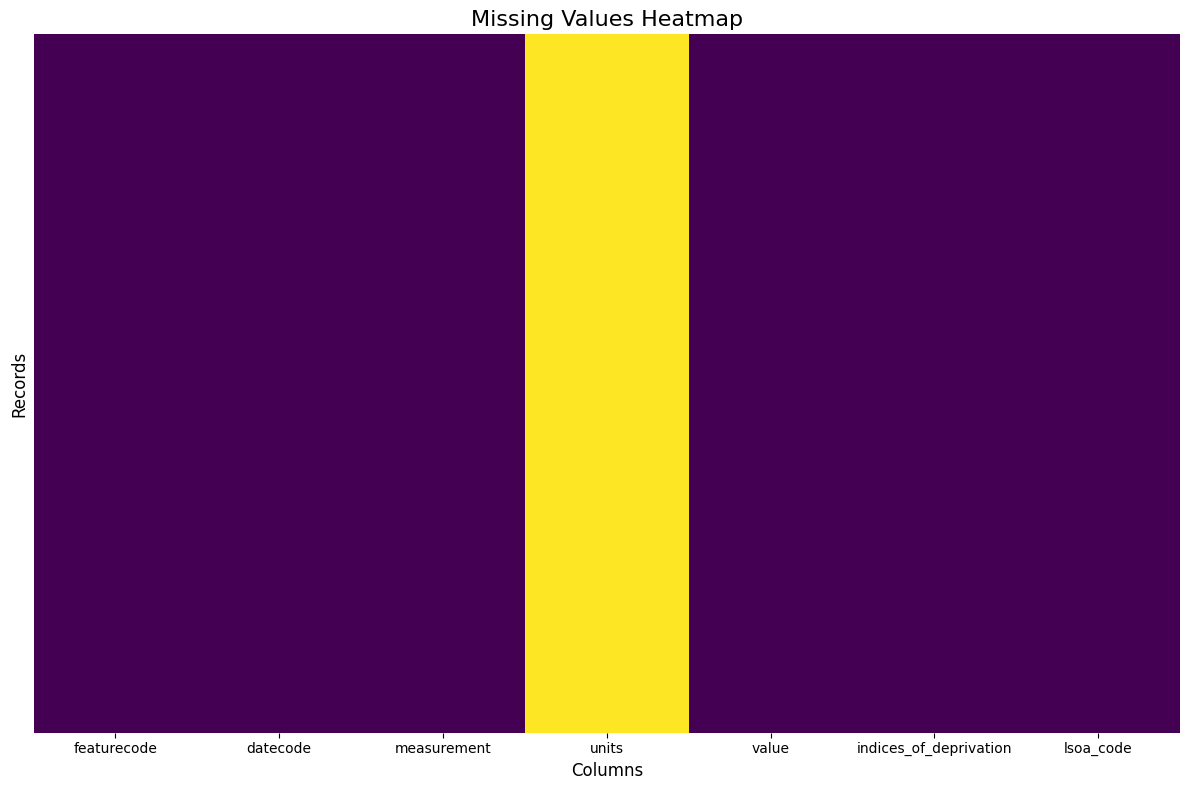

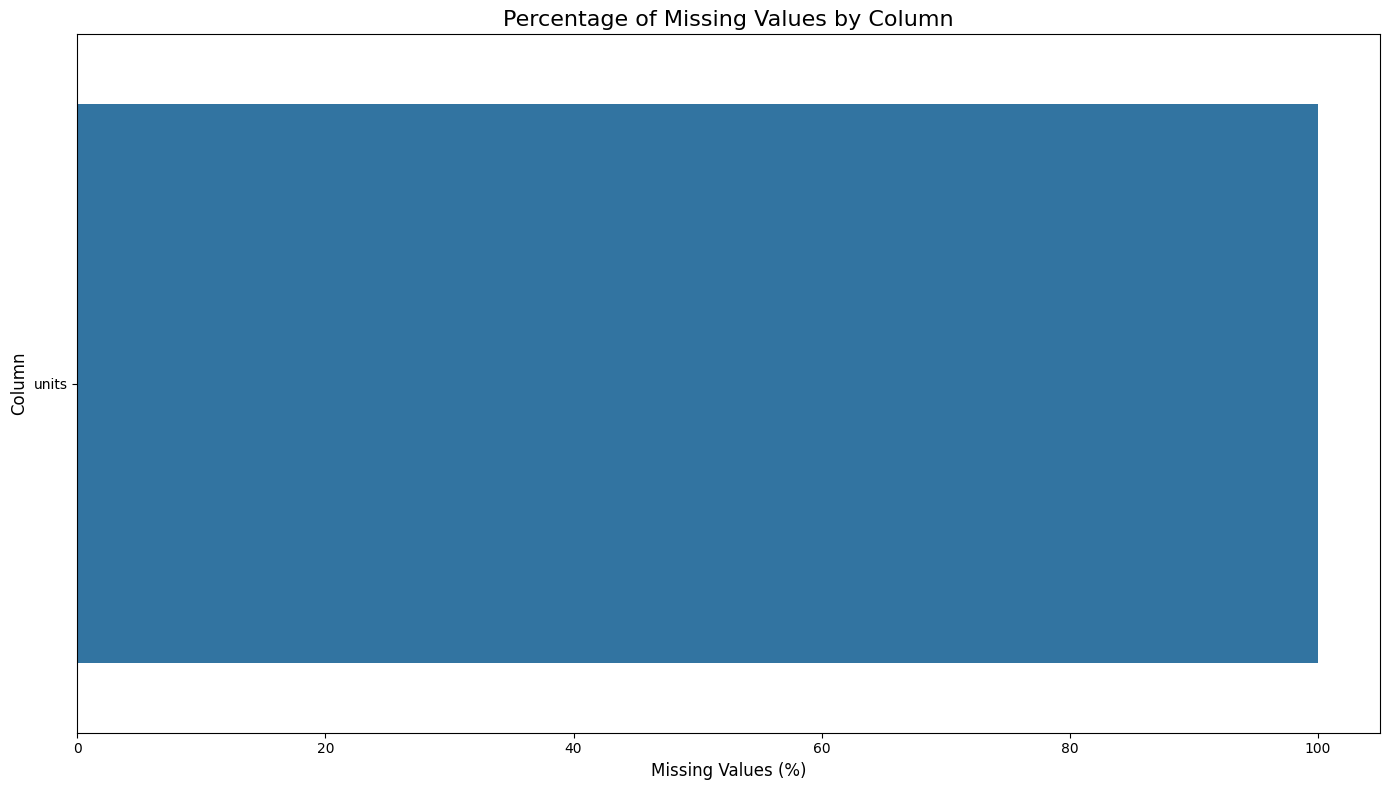

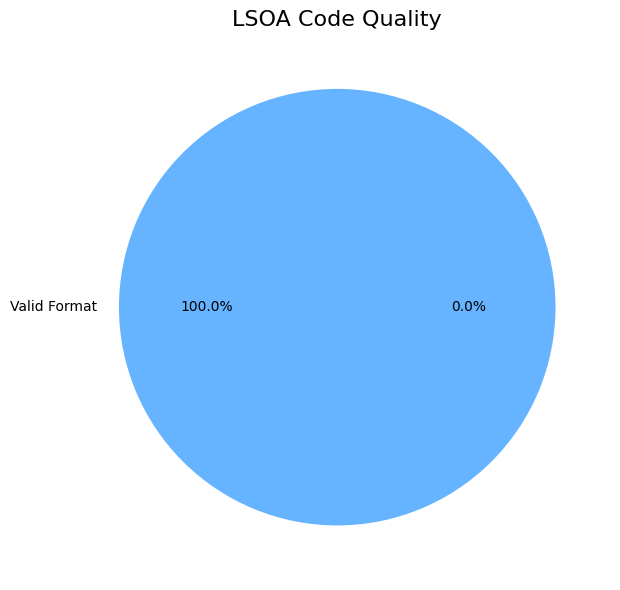

In [79]:
# Example usage
if __name__ == "__main__":
    # Replace with your actual file path and LSOA column name
    file_path = 'data/rawdata/water/indices_of_deprivation.csv'
    lsoa_column_name = 'FeatureCode'

    # Process the dataset
    cleaned_df, output_files = analyze_lsoa_dataset(file_path, lsoa_column_name, output_dir="data/preprocessed/water")

    print("\nProcessing complete!")
    print(f"Cleaned dataset: {output_files['cleaned_file']}")
    print(f"Analysis report: {output_files['report_file']}")
    print("Visualizations saved to output directory")

In [80]:
df = pd.read_csv("data/preprocessed/water/indices_of_deprivation_cleaned.csv")
df.head()

,featurecode,datecode,measurement,units,value,indices_of_deprivation,lsoa_code
0,E01005278,2019,Rank,NaN,11281.0,b. Income Deprivation Domain,E01005278
1,E01006616,2019,Decile,NaN,1.0,a. Index of Multiple Deprivation (IMD),E01006616
2,E01005236,2019,Rank,NaN,4565.0,b. Income Deprivation Domain,E01005236
3,E01031873,2019,Rank,NaN,25826.0,b. Income Deprivation Domain,E01031873
4,E01007367,2019,Decile,NaN,2.0,a. Index of Multiple Deprivation (IMD),E01007367


In [29]:
df = pd.read_csv("data/preprocessed/transport/distance_travelled_to_work_cleaned.csv")
df.head()

,lsoa_name,lsoa_code,total_employed_residents,commute_under_2km,commute_2km_to_5km,commute_5km_to_10km,commute_10km_to_20km,commute_20km_to_30km,commute_30km_to_40km,commute_40km_to_60km,commute_60km_plus,works_from_home,works_no_fixed_place
0,Bury 001A,E01005014,722,66,22,113,123,44,14,3,4,241,92
1,Bury 001B,E01005015,691,41,35,128,103,53,4,5,2,211,109
2,Bury 001C,E01005016,847,69,27,110,155,43,11,5,4,329,94
3,Bury 001D,E01005017,961,70,37,176,161,39,13,6,15,339,105
4,Bury 001E,E01005018,776,91,32,122,131,29,7,4,4,272,84


## Filter Greater Manchester data

In [83]:
def filter_by_valid_gm_lsoa(
    dataset_path,
    gm_lookup_path,
    lsoa_column_name,
    output_dir="data/preprocessed"
):
    """
    Filter a dataset to keep only records with LSOA codes that exist in the Greater Manchester lookup file.

    Parameters:
    dataset_path (str): Path to the dataset file to filter (CSV, Excel, etc.)
    gm_lookup_path (str): Path to the Greater Manchester LSOA lookup file (CSV)
    lsoa_column_name (str): Name of the column containing LSOA codes in the input dataset
    output_dir (str): Directory to save output files and visualizations

    Returns:
    pd.DataFrame: Filtered dataset containing only valid Greater Manchester LSOA codes
    dict: Dictionary with paths to output files
    """
    import pandas as pd
    import os
    import matplotlib.pyplot as plt
    import seaborn as sns
    from datetime import datetime

    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Generate timestamp for unique filenames
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Extract base filename for reporting
    base_filename = os.path.basename(dataset_path).split('.')[0]

    print(f"Loading dataset: {dataset_path}")

    # Load the dataset
    if dataset_path.endswith('.csv'):
        df = pd.read_csv(dataset_path, low_memory=False)
    elif dataset_path.endswith(('.xls', '.xlsx')):
        df = pd.read_excel(dataset_path)
    else:
        raise ValueError("Unsupported file format. Please use CSV or Excel.")

    print(f"Original dataset shape: {df.shape}")

    # Load the GM LSOA lookup file
    print(f"Loading GM LSOA lookup: {gm_lookup_path}")
    if gm_lookup_path.endswith('.csv'):
        gm_lookup = pd.read_csv(gm_lookup_path)
    elif gm_lookup_path.endswith(('.xls', '.xlsx')):
        gm_lookup = pd.read_excel(gm_lookup_path)
    else:
        raise ValueError("Unsupported file format for lookup. Please use CSV or Excel.")

    # Get column name containing LSOA codes in the lookup file
    # This assumes the first column with 'lsoa' in the name is the LSOA code column
    lsoa_lookup_columns = [col for col in gm_lookup.columns if 'lsoa' in col.lower()]
    if not lsoa_lookup_columns:
        raise ValueError("Could not identify LSOA code column in lookup file. Please specify manually.")

    gm_lsoa_column = lsoa_lookup_columns[0]
    print(f"Using LSOA column from lookup file: {gm_lsoa_column}")

    # Create a set of valid Greater Manchester LSOA codes for faster lookup
    valid_gm_lsoa_codes = set(gm_lookup[gm_lsoa_column].astype(str))
    print(f"Found {len(valid_gm_lsoa_codes)} valid Greater Manchester LSOA codes")

    # Standardize column name for consistency
    lsoa_column_name = lsoa_column_name.lower().replace(' ', '_')

    # Make sure the LSOA column exists in the dataset
    if lsoa_column_name not in [col.lower().replace(' ', '_') for col in df.columns]:
        raise ValueError(f"LSOA column '{lsoa_column_name}' not found in dataset")

    # Map original column name to standardized name
    original_to_standardized = {col: col.lower().replace(' ', '_') for col in df.columns}
    standardized_to_original = {v: k for k, v in original_to_standardized.items()}

    # Get the original column name
    original_lsoa_column = standardized_to_original.get(lsoa_column_name, lsoa_column_name)

    # Create a new column indicating if the LSOA code is valid (in Greater Manchester)
    df['is_valid_gm_lsoa'] = df[original_lsoa_column].astype(str).apply(lambda x: x in valid_gm_lsoa_codes)

    # Count valid vs invalid LSOA codes
    valid_count = df['is_valid_gm_lsoa'].sum()
    invalid_count = len(df) - valid_count

    print(f"Valid GM LSOA codes: {valid_count}/{len(df)} ({valid_count/len(df):.2%})")
    print(f"Invalid or non-GM LSOA codes: {invalid_count}/{len(df)} ({invalid_count/len(df):.2%})")

    # Create visualizations before filtering
    plt.figure(figsize=(10, 6))
    lsoa_validity = pd.Series({
        'Valid GM LSOA': valid_count,
        'Invalid or non-GM LSOA': invalid_count
    })
    lsoa_validity.plot(kind='pie', autopct='%1.1f%%', colors=['#66b3ff', '#ff9999'])
    plt.title('LSOA Code Validity in Greater Manchester', fontsize=16)
    plt.ylabel('')  # Hide the ylabel
    plt.tight_layout()
    pie_chart_path = f"{output_dir}/{base_filename}_{timestamp}_gm_lsoa_validity.png"
    plt.savefig(pie_chart_path, dpi=300)

    # Filter the dataset to keep only records with valid GM LSOA codes
    df_filtered = df[df['is_valid_gm_lsoa'] == True].copy()

    # Remove the temporary validation column
    df_filtered.drop(columns=['is_valid_gm_lsoa'], inplace=True)

    print(f"Filtered dataset shape: {df_filtered.shape}")
    print(f"Removed {len(df) - len(df_filtered)} records with invalid or non-GM LSOA codes")

    # Save the filtered dataset
    filtered_file_path = f"{output_dir}/{base_filename}_gm_filtered.csv"
    df_filtered.to_csv(filtered_file_path, index=False)
    print(f"Filtered dataset saved to: {filtered_file_path}")

    # Generate a detailed report
    report_path = f"{output_dir}/{base_filename}_{timestamp}_gm_filtering_report.txt"
    with open(report_path, "w") as f:
        f.write(f"Greater Manchester LSOA Filtering Report\n")
        f.write(f"=====================================\n\n")
        f.write(f"Dataset: {dataset_path}\n")
        f.write(f"GM Lookup: {gm_lookup_path}\n")
        f.write(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")

        f.write(f"Filtering Statistics:\n")
        f.write(f"--------------------\n")
        f.write(f"Original records: {len(df)}\n")
        f.write(f"Records with valid GM LSOA codes: {valid_count} ({valid_count/len(df):.2%})\n")
        f.write(f"Records with invalid or non-GM LSOA codes: {invalid_count} ({invalid_count/len(df):.2%})\n")
        f.write(f"Records after filtering: {len(df_filtered)}\n\n")

        f.write(f"LSOA Code Information:\n")
        f.write(f"---------------------\n")
        f.write(f"Total valid Greater Manchester LSOA codes in lookup: {len(valid_gm_lsoa_codes)}\n")
        f.write(f"Unique LSOA codes in filtered dataset: {df_filtered[original_lsoa_column].nunique()}\n\n")

        # Add some examples of invalid codes if there were any
        if invalid_count > 0:
            invalid_examples = df[~df['is_valid_gm_lsoa']][original_lsoa_column].astype(str).drop_duplicates().head(10).tolist()
            f.write(f"Examples of invalid or non-GM LSOA codes (up to 10):\n")
            for code in invalid_examples:
                f.write(f"- {code}\n")

        f.write("\nOutput Files:\n")
        f.write(f"------------\n")
        f.write(f"1. Filtered dataset: {filtered_file_path}\n")
        f.write(f"2. LSOA validity pie chart: {pie_chart_path}\n")

    print(f"Filtering report saved to: {report_path}")

    # Create a dictionary with paths to output files
    output_files = {
        'filtered_file': filtered_file_path,
        'report_file': report_path,
        'validity_chart': pie_chart_path
    }

    return df_filtered, output_files

Loading dataset: data/preprocessed/water/indices_of_deprivation_cleaned.csv
Original dataset shape: (985320, 7)
Loading GM LSOA lookup: data/gm_oa_lookup2011.xlsx
Using LSOA column from lookup file: LSOA11CD
Found 1673 valid Greater Manchester LSOA codes
Valid GM LSOA codes: 50190/985320 (5.09%)
Invalid or non-GM LSOA codes: 935130/985320 (94.91%)
Filtered dataset shape: (50190, 7)
Removed 935130 records with invalid or non-GM LSOA codes
Filtered dataset saved to: data/preprocessed/water/indices_of_deprivation_cleaned_gm_filtered.csv
Filtering report saved to: data/preprocessed/water/indices_of_deprivation_cleaned_20250410_215911_gm_filtering_report.txt
   featurecode  datecode measurement  units    value  \
0    E01005278      2019        Rank    NaN  11281.0   
2    E01005236      2019        Rank    NaN   4565.0   
10   E01006030      2019        Rank    NaN   6317.0   
11   E01005118      2019        Rank    NaN  12595.0   
12   E01005317      2019        Rank    NaN   3409.0   

 

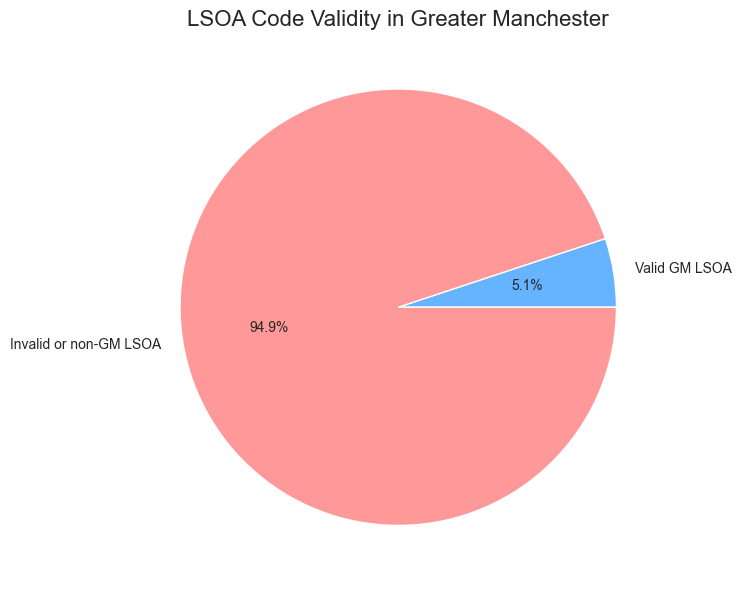

In [84]:
# Path to your dataset
dataset_path = "data/preprocessed/water/indices_of_deprivation_cleaned.csv"

# Path to the Greater Manchester LSOA lookup file
gm_lookup_path = "data/gm_oa_lookup2011.xlsx"

# Name of the column containing LSOA codes in your dataset
lsoa_column_name = "lsoa_code"

# Call the function
filtered_df, output_files = filter_by_valid_gm_lsoa(
    dataset_path,
    gm_lookup_path,
    lsoa_column_name,
    output_dir="data/preprocessed/water"
)

# Access the filtered dataframe
print(filtered_df.head())

# Access output file paths
print(f"Filtered dataset saved to: {output_files['filtered_file']}")
print(f"Report saved to: {output_files['report_file']}")

### Checking missing value

In [44]:
import pandas as pd

# Load your dataset
df = pd.read_csv("data/preprocessed/water/indices_of_deprivation_gm_filtered.csv")  # or pd.read_excel(), pd.read_json(), etc.

# 1. Check for any missing values in the entire DataFrame
print(df.isnull().values.any())

# 2. Get the number of missing values per column
print(df.isnull().sum())

# 3. Get the percentage of missing values per column
print((df.isnull().sum() / len(df)) * 100)

# 4. Get rows with missing values (optional)
missing_rows = df[df.isnull().any(axis=1)]
print(missing_rows)


True
FeatureCode                   0
DateCode                      0
Measurement                   0
Units                     49080
Value                         0
Indices of Deprivation        0
dtype: int64
FeatureCode                 0.0
DateCode                    0.0
Measurement                 0.0
Units                     100.0
Value                       0.0
Indices of Deprivation      0.0
dtype: float64
      FeatureCode  DateCode Measurement  Units      Value  \
0       E01005278      2019        Rank    NaN  11281.000   
1       E01005236      2019        Rank    NaN   4565.000   
2       E01006030      2019        Rank    NaN   6317.000   
3       E01005118      2019        Rank    NaN  12595.000   
4       E01005317      2019        Rank    NaN   3409.000   
...           ...       ...         ...    ...        ...   
49075   E01005030      2019       Score    NaN     42.818   
49076   E01004849      2019       Score    NaN     42.457   
49077   E01004890      2019       

## indice_of_deprivation

In [95]:
df = pd.read_csv("data/preprocessed/water/indices_of_deprivation_cleaned_gm_filtered.csv")
df.head()

,featurecode,datecode,measurement,units,value,indices_of_deprivation,lsoa_code
0,E01005278,2019,Rank,NaN,11281.0,b. Income Deprivation Domain,E01005278
1,E01005236,2019,Rank,NaN,4565.0,b. Income Deprivation Domain,E01005236
2,E01006030,2019,Rank,NaN,6317.0,b. Income Deprivation Domain,E01006030
3,E01005118,2019,Rank,NaN,12595.0,b. Income Deprivation Domain,E01005118
4,E01005317,2019,Rank,NaN,3409.0,b. Income Deprivation Domain,E01005317


In [96]:
df.columns

Index(['featurecode', 'datecode', 'measurement', 'units', 'value',
       'indices_of_deprivation', 'lsoa_code'],
      dtype='object')

In [99]:
# Step 1: Filter rows where the last column matches the IMD label
# df_filtered = df[df.iloc[:, -1] == 'a. Index of Multiple Deprivation (IMD)']

# Step 2: Drop the third column (index 2, 0-based)
df_filtered = df.drop(df.columns[3], axis=1)
df_filtered

,featurecode,datecode,measurement,units,value,indices_of_deprivation,lsoa_code


In [94]:
df_filtered.to_csv('data/preprocessed/water/indices_of_deprivation_cleaned_gm_filtered2.csv', index=False)

### employment_history

Processing dataset: data/rawdata/finance/employment_history.xlsx
Original dataset shape: (1702, 9)
Removed 0 duplicate rows. New shape: (1702, 9)
Standardized LSOA codes: 1702/1702 (100.00%)

Missing Values Analysis:
                                              Column  Missing Values  \
0                                          lsoa_code               0   
1  total:_all_usual_residents_aged_16_years_and_o...               0   
2                                                  %               0   
3    not_in_employment:_worked_in_the_last_12_months               0   
4                                                %.1               0   
5  not_in_employment:_not_worked_in_the_last_12_m...               0   
6                                                %.2               0   
7                    not_in_employment:_never_worked               0   
8                                                %.3               0   

   Percentage  
0         0.0  
1         0.0  
2         0.0 

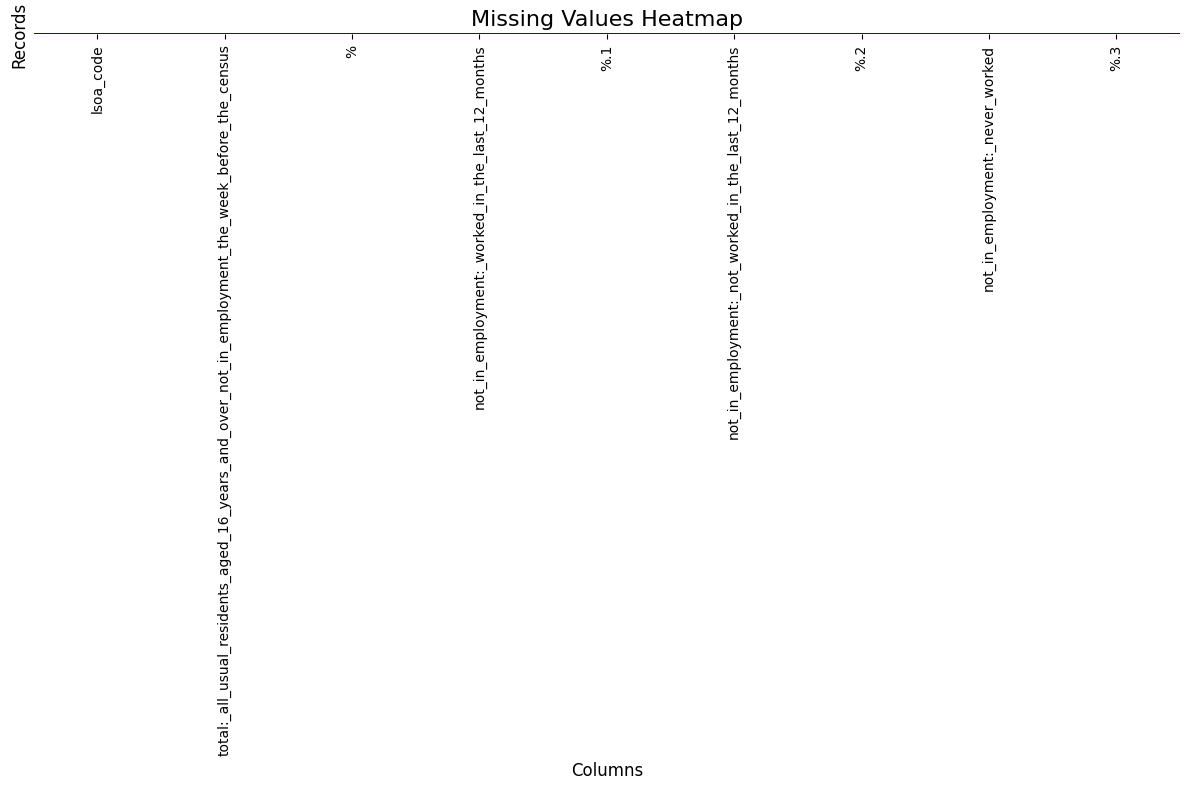

<Figure size 1400x800 with 0 Axes>

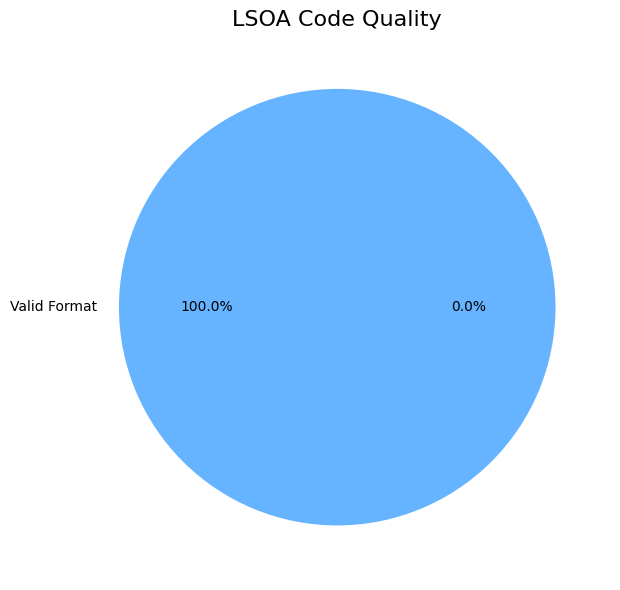

In [66]:
# Example usage
if __name__ == "__main__":
    # Replace with your actual file path and LSOA column name
    file_path = 'data/rawdata/finance/employment_history.xlsx'
    lsoa_column_name = 'lsoa_code'

    # Process the dataset
    cleaned_df, output_files = analyze_lsoa_dataset(file_path, lsoa_column_name, output_dir="data/preprocessed/finance")

    print("\nProcessing complete!")
    print(f"Cleaned dataset: {output_files['cleaned_file']}")
    print(f"Analysis report: {output_files['report_file']}")
    print("Visualizations saved to output directory")

Loading dataset: data/preprocessed/finance/employment_history_cleaned.csv
Original dataset shape: (1702, 9)
Loading GM LSOA lookup: data/gm_oa_lookup.xlsx
Using LSOA column from lookup file: LSOA21CD
Found 1702 valid Greater Manchester LSOA codes
Valid GM LSOA codes: 1702/1702 (100.00%)
Invalid or non-GM LSOA codes: 0/1702 (0.00%)
Filtered dataset shape: (1702, 9)
Removed 0 records with invalid or non-GM LSOA codes
Filtered dataset saved to: data/preprocessed/finance/employment_history_cleaned_gm_filtered.csv
Filtering report saved to: data/preprocessed/finance/employment_history_cleaned_20250409_204130_gm_filtering_report.txt
   lsoa_code  \
0  E01005098   
1  E01005099   
2  E01005100   
3  E01005102   
4  E01005103   

   total:_all_usual_residents_aged_16_years_and_over_not_in_employment_the_week_before_the_census  \
0                                                640                                                
1                                                710              

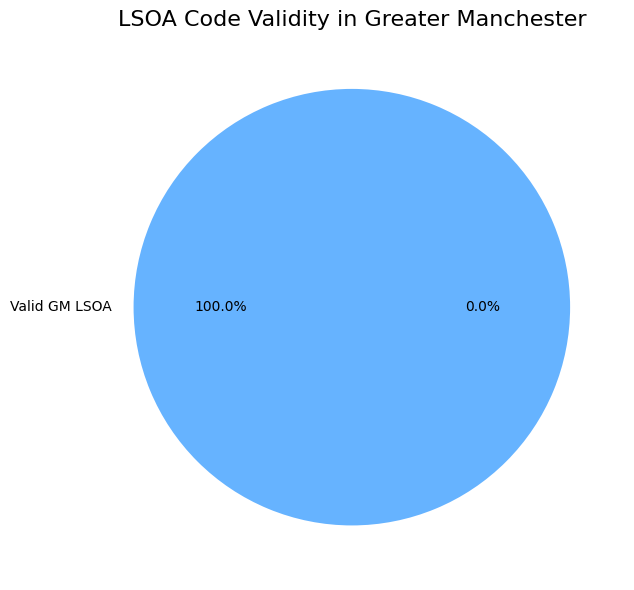

In [67]:
# Path to your dataset
dataset_path = "data/preprocessed/finance/employment_history_cleaned.csv"

# Path to the Greater Manchester LSOA lookup file
gm_lookup_path = "data/gm_oa_lookup.xlsx"

# Name of the column containing LSOA codes in your dataset
lsoa_column_name = "lsoa_code"

# Call the function
filtered_df, output_files = filter_by_valid_gm_lsoa(
    dataset_path,
    gm_lookup_path,
    lsoa_column_name,
    output_dir="data/preprocessed/finance"
)

# Access the filtered dataframe
print(filtered_df.head())

# Access output file paths
print(f"Filtered dataset saved to: {output_files['filtered_file']}")
print(f"Report saved to: {output_files['report_file']}")

In [68]:
df = pd.read_csv("data/preprocessed/finance/employment_history_cleaned_gm_filtered.csv")
df.head()

,lsoa_code,total:_all_usual_residents_aged_16_years_and_over_not_in_employment_the_week_before_the_census,%,not_in_employment:_worked_in_the_last_12_months,%.1,not_in_employment:_not_worked_in_the_last_12_months,%.2,not_in_employment:_never_worked,%.3
0,E01005098,640,100,80,12.5,335,52.3,225,35.2
1,E01005099,710,100,84,11.8,319,44.9,307,43.2
2,E01005100,600,100,74,12.3,324,54.0,202,33.7
3,E01005102,468,100,72,15.4,259,55.3,137,29.3
4,E01005103,742,100,66,8.9,385,51.9,291,39.2


In [70]:
df.columns = [
    'lsoa_code',
    'not_in_employment_total_pct',        # Total: All usual residents aged 16 years and over not in employment the week before the census
    'not_in_employment_total',            # Total: All usual residents aged 16 years and over not in employment the week before the census (non-%)

    'not_in_employment_recently_worked',  # Not in employment: Worked in the last 12 months
    'not_in_employment_recently_worked_pct',  # Not in employment: Worked in the last 12 months (%)

    'not_in_employment_not_recently_worked',  # Not in employment: Not worked in the last 12 months
    'not_in_employment_not_recently_worked_pct',  # Not in employment: Not worked in the last 12 months (%)

    'not_in_employment_never_worked',      # Not in employment: Never worked
    'not_in_employment_never_worked_pct'   # Not in employment: Never worked (%)
]
df.head()

,lsoa_code,not_in_employment_total_pct,not_in_employment_total,not_in_employment_recently_worked,not_in_employment_recently_worked_pct,not_in_employment_not_recently_worked,not_in_employment_not_recently_worked_pct,not_in_employment_never_worked,not_in_employment_never_worked_pct
0,E01005098,640,100,80,12.5,335,52.3,225,35.2
1,E01005099,710,100,84,11.8,319,44.9,307,43.2
2,E01005100,600,100,74,12.3,324,54.0,202,33.7
3,E01005102,468,100,72,15.4,259,55.3,137,29.3
4,E01005103,742,100,66,8.9,385,51.9,291,39.2


In [71]:
df.to_csv('data/preprocessed/finance/employment_history_cleaned_gm_filtered2.csv', index=False)

### economic_activity_status

Processing dataset: data/rawdata/finance/economic_activity_status.xlsx
Original dataset shape: (1702, 63)
Removed 0 duplicate rows. New shape: (1702, 63)
Standardized LSOA codes: 1702/1702 (100.00%)

Missing Values Analysis:
                                               Column  Missing Values  \
0                                           lsoa_code               0   
1   economically_active_and_a_full-time_student:_i...               0   
2                                                %.16               0   
3   economically_active_and_a_full-time_student:_i...               0   
4                                                %.17               0   
..                                                ...             ...   
58                                               %.12               0   
59        economically_active_and_a_full-time_student               0   
60                                               %.13               0   
61  economically_active_and_a_full-time_stude

/var/folders/7h/kpwlmbts6qvbvpgj641mfzjr0000gn/T/ipykernel_62269/1891654077.py:127: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


No missing values to plot

Cleaned dataset saved to: data/preprocessed/finance/economic_activity_status_cleaned.csv

Analysis report saved to: data/preprocessed/finance/economic_activity_status_20250409_204540_report.txt

Processing complete!
Cleaned dataset: data/preprocessed/finance/economic_activity_status_cleaned.csv
Analysis report: data/preprocessed/finance/economic_activity_status_20250409_204540_report.txt
Visualizations saved to output directory


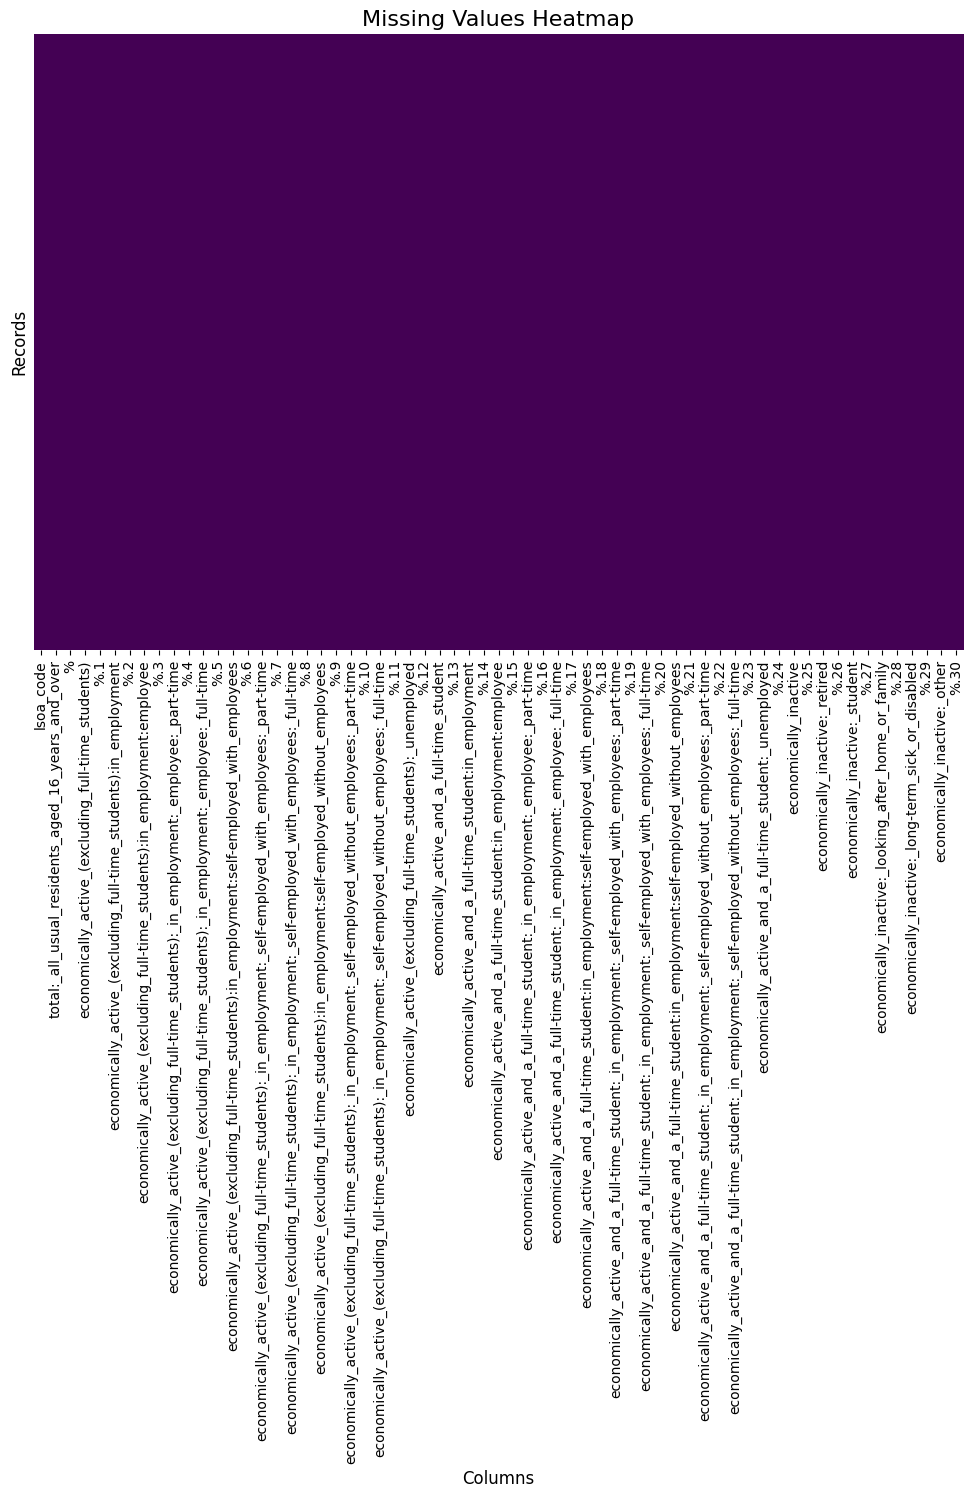

<Figure size 1400x800 with 0 Axes>

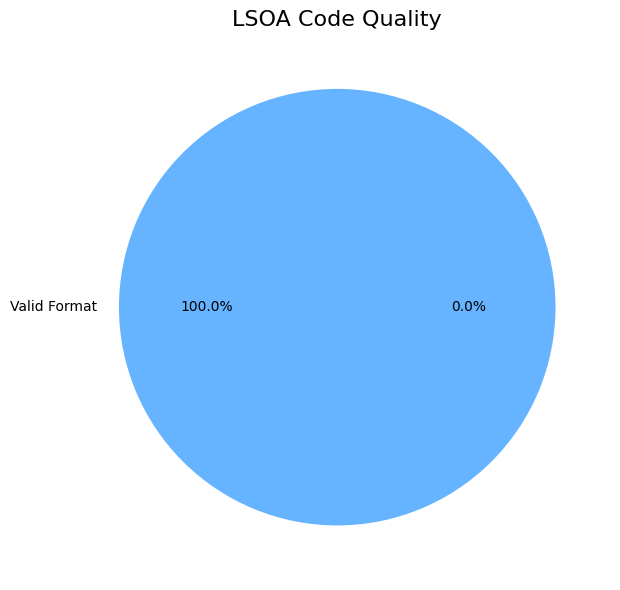

In [72]:
# Example usage
if __name__ == "__main__":
    # Replace with your actual file path and LSOA column name
    file_path = 'data/rawdata/finance/economic_activity_status.xlsx'
    lsoa_column_name = 'lsoa_code'

    # Process the dataset
    cleaned_df, output_files = analyze_lsoa_dataset(file_path, lsoa_column_name, output_dir="data/preprocessed/finance")

    print("\nProcessing complete!")
    print(f"Cleaned dataset: {output_files['cleaned_file']}")
    print(f"Analysis report: {output_files['report_file']}")
    print("Visualizations saved to output directory")

In [73]:
df = pd.read_csv("data/preprocessed/finance/economic_activity_status_cleaned.csv")
df.head()

,lsoa_code,total:_all_usual_residents_aged_16_years_and_over,%,economically_active_(excluding_full-time_students),%.1,economically_active_(excluding_full-time_students):in_employment,%.2,economically_active_(excluding_full-time_students):in_employment:employee,%.3,economically_active_(excluding_full-time_students):_in_employment:_employee:_part-time,...,economically_inactive:_retired,%.26,economically_inactive:_student,%.27,economically_inactive:_looking_after_home_or_family,%.28,economically_inactive:_long-term_sick_or_disabled,%.29,economically_inactive:_other,%.30
0,E01005098,1299,100,683,52.6,635,48.9,543,41.8,180,...,226,17.4,69,5.3,75,5.8,144,11.1,67,5.2
1,E01005099,1350,100,697,51.6,615,45.6,526,39.0,195,...,158,11.7,135,10.0,107,7.9,145,10.7,75,5.6
2,E01005100,1277,100,688,53.9,641,50.2,540,42.3,142,...,254,19.9,66,5.2,81,6.3,99,7.8,48,3.8
3,E01005102,1113,100,676,60.7,634,57.0,550,49.4,165,...,225,20.2,56,5.0,50,4.5,57,5.1,34,3.1
4,E01005103,1425,100,717,50.3,663,46.5,573,40.2,184,...,312,21.9,76,5.3,89,6.2,139,9.8,64,4.5


In [75]:
df.columns

Index(['lsoa_code', 'total:_all_usual_residents_aged_16_years_and_over', '%',
       'economically_active_(excluding_full-time_students)', '%.1',
       'economically_active_(excluding_full-time_students):in_employment',
       '%.2',
       'economically_active_(excluding_full-time_students):in_employment:employee',
       '%.3',
       'economically_active_(excluding_full-time_students):_in_employment:_employee:_part-time',
       '%.4',
       'economically_active_(excluding_full-time_students):_in_employment:_employee:_full-time',
       '%.5',
       'economically_active_(excluding_full-time_students):in_employment:self-employed_with_employees',
       '%.6',
       'economically_active_(excluding_full-time_students):_in_employment:_self-employed_with_employees:_part-time',
       '%.7',
       'economically_active_(excluding_full-time_students):_in_employment:_self-employed_with_employees:_full-time',
       '%.8',
       'economically_active_(excluding_full-time_students):in_emp

In [77]:
renamed_columns = {
    'lsoa_code': 'lsoa_code',
    'total:_all_usual_residents_aged_16_years_and_over': 'total_residents_16plus',
    '%': 'total_residents_16plus_pct',
    'economically_active_(excluding_full-time_students)': 'econ_active_excl_students',
    '%.1': 'econ_active_excl_students_pct',
    'economically_active_(excluding_full-time_students):in_employment': 'employed_excl_students',
    '%.2': 'employed_excl_students_pct',
    'economically_active_(excluding_full-time_students):in_employment:employee': 'employees_excl_students',
    '%.3': 'employees_excl_students_pct',
    'economically_active_(excluding_full-time_students):_in_employment:_employee:_part-time': 'part_time_employees_excl_students',
    '%.4': 'part_time_employees_excl_students_pct',
    'economically_active_(excluding_full-time_students):_in_employment:_employee:_full-time': 'full_time_employees_excl_students',
    '%.5': 'full_time_employees_excl_students_pct',
    'economically_active_(excluding_full-time_students):in_employment:self-employed_with_employees': 'self_emp_with_emp_excl_students',
    '%.6': 'self_emp_with_emp_excl_students_pct',
    'economically_active_(excluding_full-time_students):_in_employment:_self-employed_with_employees:_part-time': 'part_time_self_emp_with_emp_excl_students',
    '%.7': 'part_time_self_emp_with_emp_excl_students_pct',
    'economically_active_(excluding_full-time_students):_in_employment:_self-employed_with_employees:_full-time': 'full_time_self_emp_with_emp_excl_students',
    '%.8': 'full_time_self_emp_with_emp_excl_students_pct',
    'economically_active_(excluding_full-time_students):in_employment:self-employed_without_employees': 'self_emp_without_emp_excl_students',
    '%.9': 'self_emp_without_emp_excl_students_pct',
    'economically_active_(excluding_full-time_students):_in_employment:_self-employed_without_employees:_part-time': 'part_time_self_emp_without_emp_excl_students',
    '%.10': 'part_time_self_emp_without_emp_excl_students_pct',
    'economically_active_(excluding_full-time_students):_in_employment:_self-employed_without_employees:_full-time': 'full_time_self_emp_without_emp_excl_students',
    '%.11': 'full_time_self_emp_without_emp_excl_students_pct',
    'economically_active_(excluding_full-time_students):_unemployed': 'unemployed_excl_students',
    '%.12': 'unemployed_excl_students_pct',
    'economically_active_and_a_full-time_student': 'econ_active_students',
    '%.13': 'econ_active_students_pct',
    'economically_active_and_a_full-time_student:in_employment': 'employed_students',
    '%.14': 'employed_students_pct',
    'economically_active_and_a_full-time_student:in_employment:employee': 'employee_students',
    '%.15': 'employee_students_pct',
    'economically_active_and_a_full-time_student:_in_employment:_employee:_part-time': 'part_time_employee_students',
    '%.16': 'part_time_employee_students_pct',
    'economically_active_and_a_full-time_student:_in_employment:_employee:_full-time': 'full_time_employee_students',
    '%.17': 'full_time_employee_students_pct',
    'economically_active_and_a_full-time_student:in_employment:self-employed_with_employees': 'self_emp_with_emp_students',
    '%.18': 'self_emp_with_emp_students_pct',
    'economically_active_and_a_full-time_student:_in_employment:_self-employed_with_employees:_part-time': 'part_time_self_emp_with_emp_students',
    '%.19': 'part_time_self_emp_with_emp_students_pct',
    'economically_active_and_a_full-time_student:_in_employment:_self-employed_with_employees:_full-time': 'full_time_self_emp_with_emp_students',
    '%.20': 'full_time_self_emp_with_emp_students_pct',
    'economically_active_and_a_full-time_student:in_employment:self-employed_without_employees': 'self_emp_without_emp_students',
    '%.21': 'self_emp_without_emp_students_pct',
    'economically_active_and_a_full-time_student:_in_employment:_self-employed_without_employees:_part-time': 'part_time_self_emp_without_emp_students',
    '%.22': 'part_time_self_emp_without_emp_students_pct',
    'economically_active_and_a_full-time_student:_in_employment:_self-employed_without_employees:_full-time': 'full_time_self_emp_without_emp_students',
    '%.23': 'full_time_self_emp_without_emp_students_pct',
    'economically_active_and_a_full-time_student:_unemployed': 'unemployed_students',
    '%.24': 'unemployed_students_pct',
    'economically_inactive': 'econ_inactive',
    '%.25': 'econ_inactive_pct',
    'economically_inactive:_retired': 'retired',
    '%.26': 'retired_pct',
    'economically_inactive:_student': 'inactive_students',
    '%.27': 'inactive_students_pct',
    'economically_inactive:_looking_after_home_or_family': 'home_or_family',
    '%.28': 'home_or_family_pct',
    'economically_inactive:_long-term_sick_or_disabled': 'long_term_sick_disabled',
    '%.29': 'long_term_sick_disabled_pct',
    'economically_inactive:_other': 'inactive_other',
    '%.30': 'inactive_other_pct'
}

df = df.rename(columns=renamed_columns)
df.head()


,lsoa_code,total_residents_16plus,total_residents_16plus_pct,econ_active_excl_students,econ_active_excl_students_pct,employed_excl_students,employed_excl_students_pct,employees_excl_students,employees_excl_students_pct,part_time_employees_excl_students,...,retired,retired_pct,inactive_students,inactive_students_pct,home_or_family,home_or_family_pct,long_term_sick_disabled,long_term_sick_disabled_pct,inactive_other,inactive_other_pct
0,E01005098,1299,100,683,52.6,635,48.9,543,41.8,180,...,226,17.4,69,5.3,75,5.8,144,11.1,67,5.2
1,E01005099,1350,100,697,51.6,615,45.6,526,39.0,195,...,158,11.7,135,10.0,107,7.9,145,10.7,75,5.6
2,E01005100,1277,100,688,53.9,641,50.2,540,42.3,142,...,254,19.9,66,5.2,81,6.3,99,7.8,48,3.8
3,E01005102,1113,100,676,60.7,634,57.0,550,49.4,165,...,225,20.2,56,5.0,50,4.5,57,5.1,34,3.1
4,E01005103,1425,100,717,50.3,663,46.5,573,40.2,184,...,312,21.9,76,5.3,89,6.2,139,9.8,64,4.5


In [78]:
df.to_csv("data/preprocessed/finance/economic_activity_status_cleaned2.csv", index=False)